**Modules Used**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [7]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.74G/1.76G [00:16<00:00, 191MB/s]
100% 1.76G/1.76G [00:16<00:00, 114MB/s]


In [9]:

# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/lung-and-colon-cancer-histopathological-images.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [33]:

!ls

kaggle.json  lung-and-colon-cancer-histopathological-images.zip  lung_colon_image_set  sample_data


**Data Visualization**

In [10]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

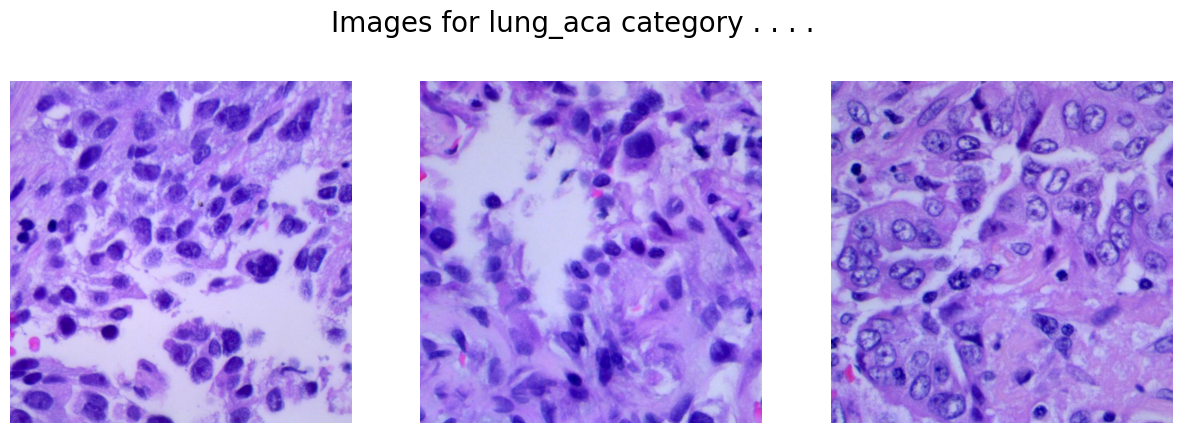

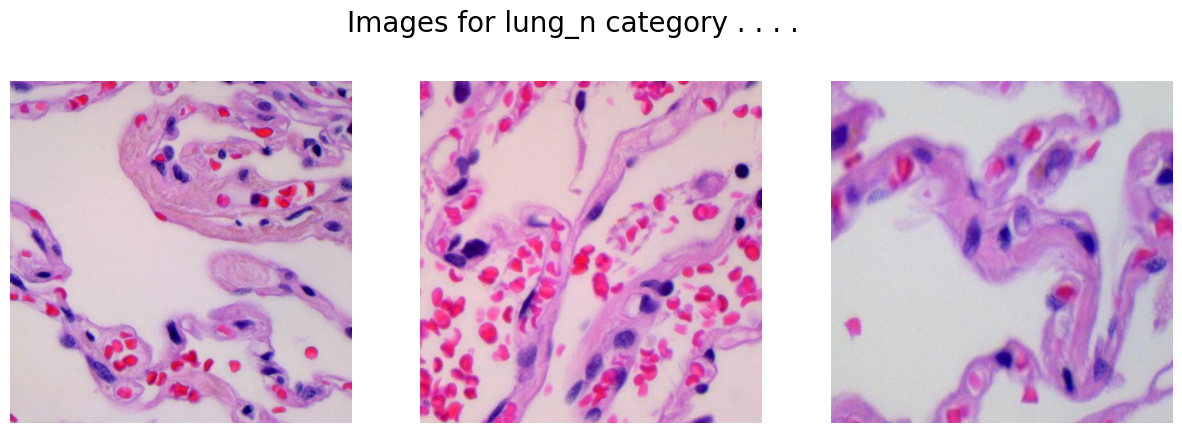

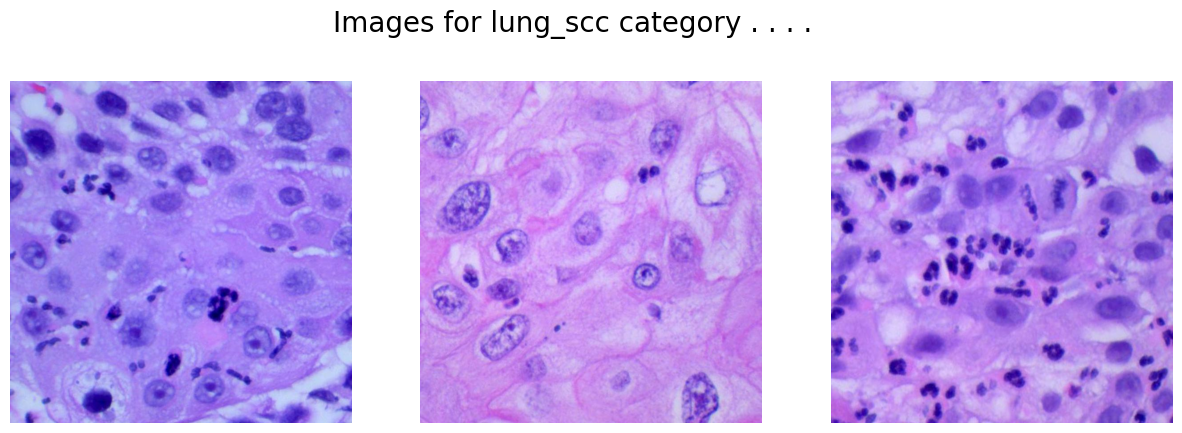

In [12]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


**Data Preparation for Training**

In [37]:
dirpath='/content/lung_colon_image_set/colon_image_sets'
IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 2
# classes=['Colon adenocarcinoma'
# 'Colon benign tissue'

In [38]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 2 classes.


In [39]:
classes_name=dataset.class_names
classes_name

['colon_aca', 'colon_n']

In [40]:
for batch_img,batch_label in dataset.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

(32, 180, 180, 3)
[1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1]


In [41]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

In [42]:
train,val,test=split_train_val_test(dataset)

In [43]:
print(len(train))
print(len(test))
print(len(val))

250
31
31


In [44]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

In [46]:
cnn_model=tf.keras.models.Sequential([
    resize_scaling,
    layers.Conv2D(32, kernel_size = (3,3),padding='same',activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])

In [47]:
cnn_model.build(input_shape=INPUT_SHAPE)

In [48]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 180, 180, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 90, 90, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 90, 90, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 45, 45, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 43, 43, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 21, 21, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 19, 19, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 9, 9, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 9, 9, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 5184)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         331,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425,474 (1.62 MB)

 Trainable params: 425,346 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

In [50]:
from tensorflow.keras import callbacks
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = 'logs')
checkpoint =tf.keras.callbacks.ModelCheckpoint("colon.keras",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [51]:
cnn_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [52]:
history=cnn_model.fit(train_ds,validation_data=val_ds,epochs=40,batch_size=BATCH_SIZE,verbose=1,
             callbacks=[tensorboard,checkpoint,early_stopping,reduce_lr])

Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8628 - loss: 0.3163
Epoch 1: val_loss improved from inf to 5.80089, saving model to colon.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 725s 3s/step - accuracy: 0.8629 - loss: 0.3160 - val_accuracy: 0.5020 - val_loss: 5.8009 - learning_rate: 0.0010
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9528 - loss: 0.1294
Epoch 2: val_loss improved from 5.80089 to 0.28607, saving model to colon.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.9528 - loss: 0.1294 - val_accuracy: 0.9042 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9711 - loss: 0.0773
Epoch 3: val_loss did not improve from 0.28607
250/250 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - accuracy: 0.9711 - loss: 0.0773 - val_accuracy: 0.4980 - val_loss: 59.7714 - learning_rate: 0.0010
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9823 - loss: 0.0495
Epoch 4: val_loss did not impr

In [53]:
cnn_model.evaluate(test_ds)

31/31 ━━━━━━━━━━━━━━━━━━━━ 60s 660ms/step - accuracy: 0.9962 - loss: 0.0112


[0.016254469752311707, 0.9969757795333862]

**Evaluate The Model¶**

In [54]:
train_score = cnn_model.evaluate(train_ds, verbose= 1)
valid_score = cnn_model.evaluate(val_ds, verbose= 1)
test_score =cnn_model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 663ms/step - accuracy: 0.9999 - loss: 0.0013
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.9960 - loss: 0.0076
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 661ms/step - accuracy: 0.9959 - loss: 0.0266
Train Loss:  0.0014554646331816912
Train Accuracy:  0.999749481678009
--------------------
Validation Loss:  0.007996001280844212
Validation Accuracy:  0.9959677457809448
--------------------
Test Loss:  0.016254469752311707
Test Accuracy:  0.9969757795333862


**Show The Model performance!**

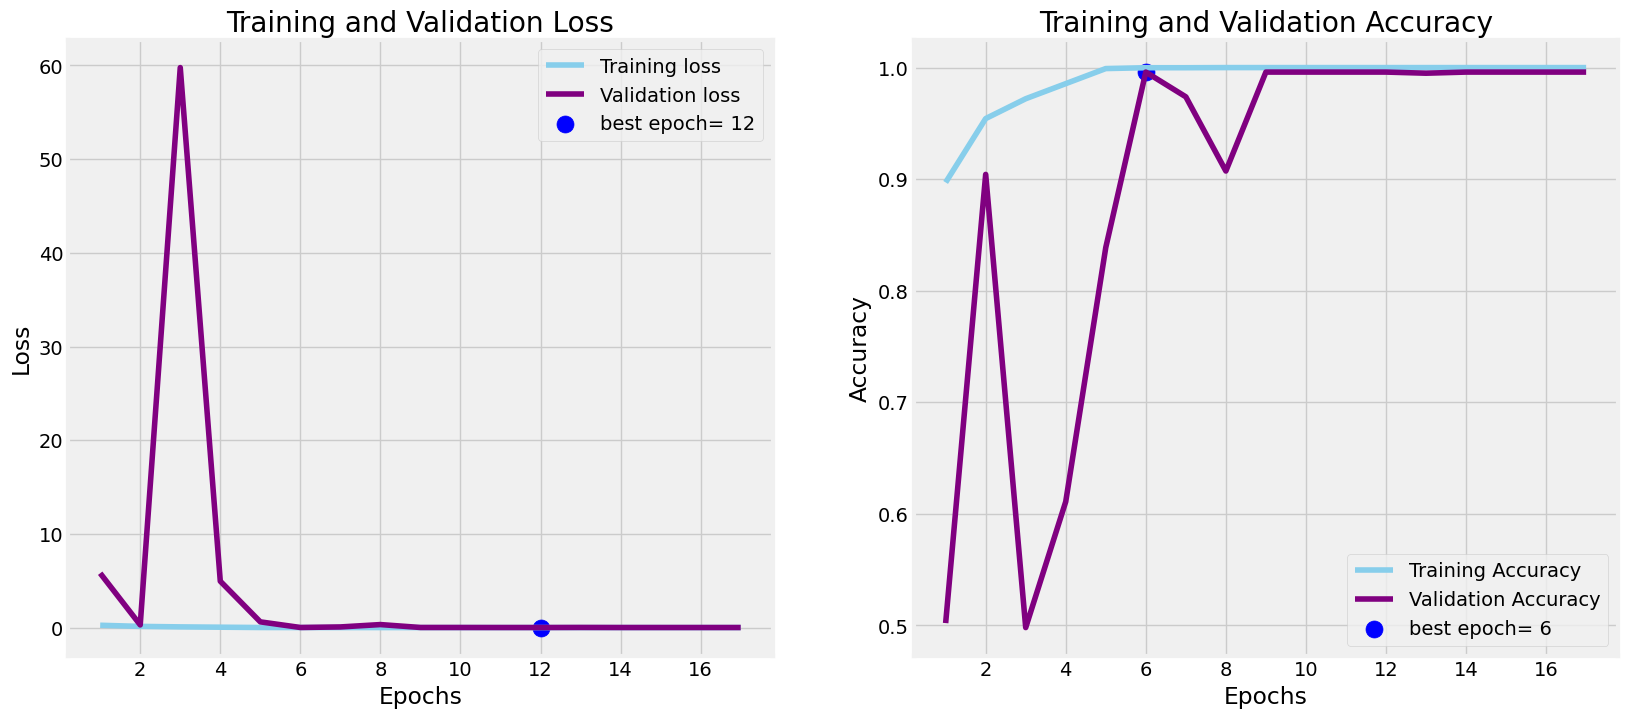

In [55]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'skyblue', label= 'Training loss')
plt.plot(Epochs, val_loss, 'purple', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'skyblue', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'purple', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

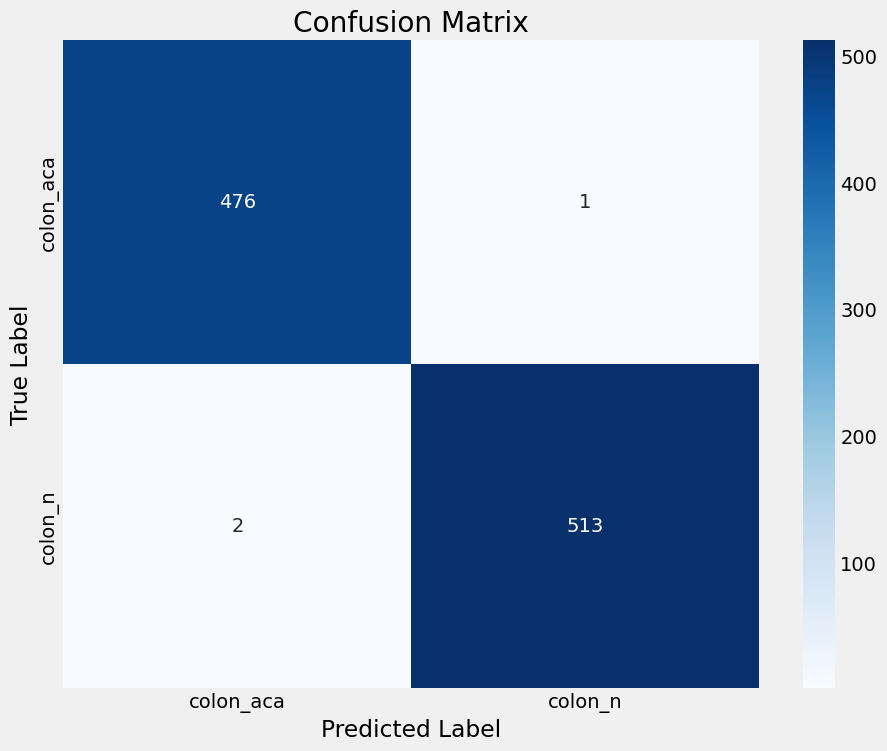

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def display_conf_matrix():
    all_true_labels = []
    all_predicted_labels = []

    # Assuming 'dataset.class_names' contains the names of the classes
    classes_name = dataset.class_names

    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = cnn_model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # No need to convert if labels are not one-hot encoded
        true_labels = label_batch

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    # Print classification report
    print(classification_report(all_true_labels, all_predicted_labels, target_names=classes_name))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Now call the function
display_conf_matrix()


**get predictions!**

In [61]:
def get_predicitions():
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]

    classes_name=dataset.class_names
    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = cnn_model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

            print(len(all_true_labels))
    #plot the predictions
    index=0
    plt.figure(figsize=(20, 20))
    plt.suptitle('Prediction of Colon Cancer!')

    for i in range(30,61):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class:{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
32
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
64
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
96
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
128
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
192
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
224
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
256
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
288
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
320
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
352
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
384
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
416
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
448
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
480
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
512
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
544
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
576
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
608
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
640
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
672
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
704
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
736
1/1 ━━━━━━━━━━━━━━━━

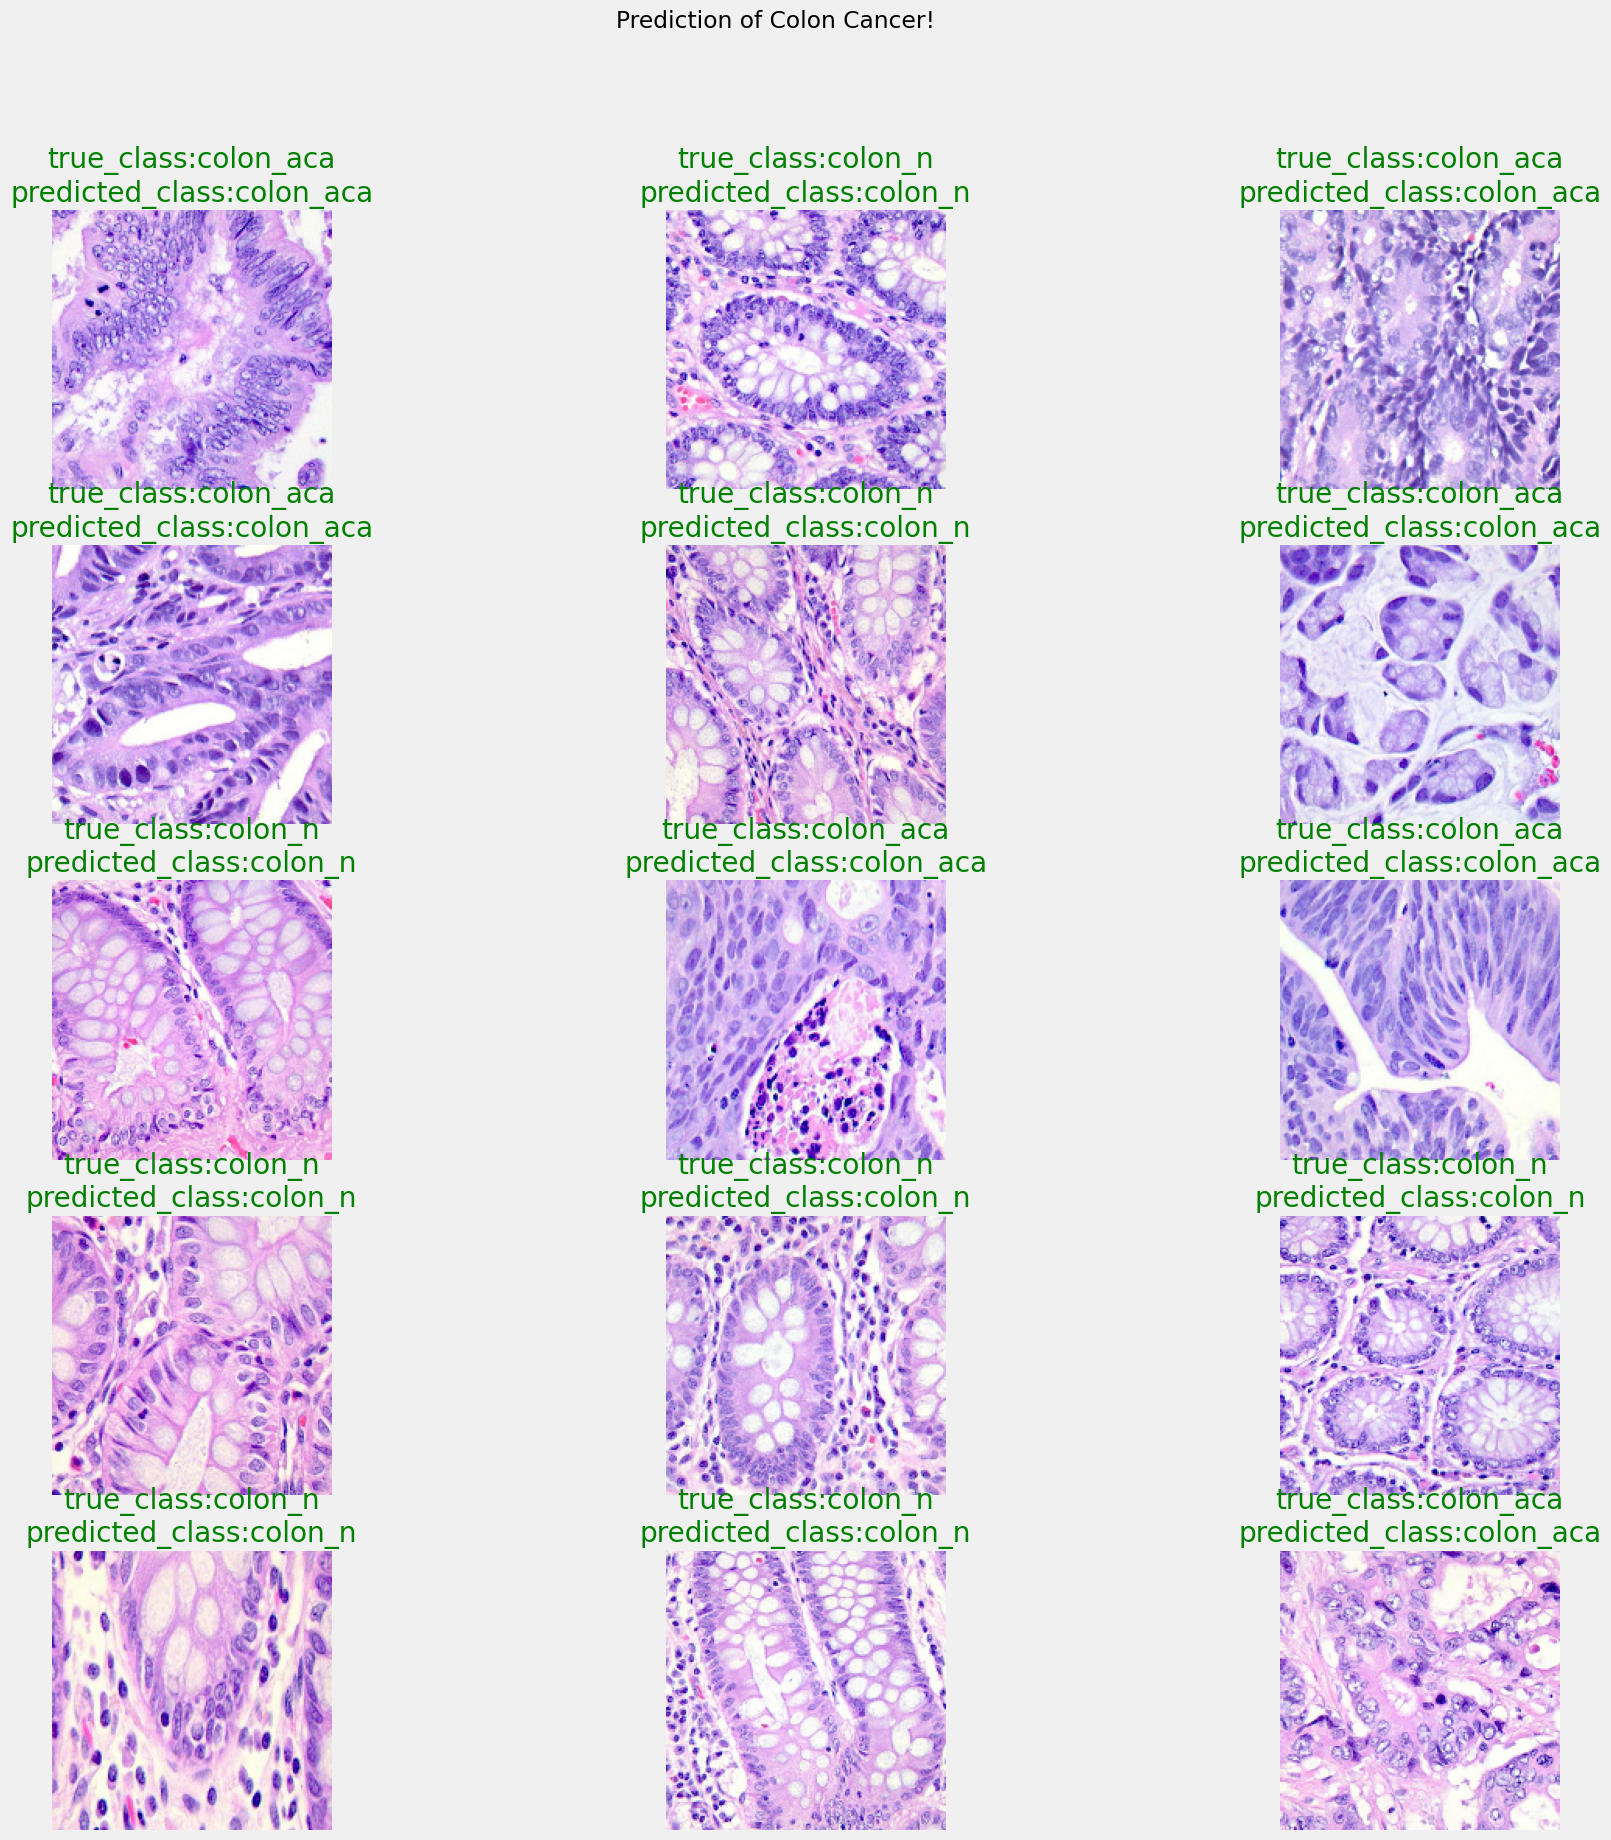

In [62]:
get_predicitions()